## **Multiscale Clustering of Molecular Localizations Using MIRO**

This tutorial demonstrates how to train and apply **MIRO** for multiscale clustering of spatial point clouds from single-molecule localization microscopy (SMLM), focusing on nuclear pore complex datasets.

We show how to train **MIRO** using simulated data and then evaluate its performance on experimental SMLM datasets. In addition, the tutorial covers how to build custom data loaders tailored to the structure and format of each dataset, an essential step for applying MIRO to diverse real-world scenarios.

In [1]:
import sys
from pathlib import Path

# Ensure the library path is in sys.path
lib_path = Path.cwd().parent.resolve()

if str(lib_path) not in sys.path:
    sys.path.insert(0, str(lib_path))

import lib

### **1. Load the Data**

To begin, load the training dataset.

It consists of pre-generated synthetic images, each containing between 5 and 9 nuclear pore-like structures. Each structure is composed of 8 *corners* arranged symmetrically around a shared central vertex, mimicking the characteristic geometry of nuclear pore complexes.

In [2]:
import pandas as pd

training_data = pd.read_csv("data/training_data.csv")

### **2. Build the training dataset**


Next, we create the training dataset by converting each synthetic image into a graph-based representation compatible with **MIRO**. The code snippet below demonstrates how to build a custom data loader tailored to this multiscale setting.

The `MultiscaleGraphDataset` class reads each training image, computes the ground truth displacement vectors for each scale (in this case, two: the *ring* structure and the inner *corners*), and constructs a graph based on spatial connectivity. Nodes in the graph represent individual molecular localizations, while edges are defined using Delaunay triangulation and filtered by a connectivity radius.

For each image (field of view), the loader returns a `torch_geometric.data.Data` object, storing the graph structure, positional features, and scale-specific ground truth displacements. These data objects form the input to the MIRO model during training.

In [3]:
import numpy as np
import matplotlib.tri as tri
import itertools
import tqdm

import torch
from torch_geometric.transforms import AddLaplacianEigenvectorPE
from torch_geometric.data import Data


class MultiscaleGraphDataset:
    def __init__(
        self,
        training_images,
        connectivity_radius=1,
    ):
        self.training_images = training_images
        self.connectivity_radius = connectivity_radius

        self.laplacian_embedding = AddLaplacianEigenvectorPE(
            5, attr_name="x", is_undirected=True
        )

    def __call__(self):
        return self.generate_dataset()

    def generate_dataset(self):
        """Generate a dataset of graph-structured data."""
        dataset = []
        for _, df_set in tqdm.tqdm_notebook(
            self.training_images.groupby("set", sort=False),
            desc="Generating dataset",
        ):
            positions = df_set[["x", "y"]].to_numpy()

            cluster_means = self.compute_position_means(df_set, "label")
            subcluster_means = self.compute_position_means(df_set, "sublabel")

            deltas = positions - cluster_means
            subdeltas = positions - subcluster_means

            data = self.create_data_object(positions, subdeltas, deltas)
            dataset.append(data)

        return dataset

    def compute_position_means(self, df, group_col: str) -> np.ndarray:
        return (
            df.groupby(group_col)[["x", "y"]]
            .transform("mean")
            .mask(df[group_col].eq(0.0), df[["x", "y"]])
            .to_numpy()
        )

    def create_data_object(self, positions, subdeltas, deltas):
        """Create a `Data` object from positions and deltas."""
        data = Data()

        # Prepare ground truth displacements
        data.y_sub, data.y = (
            torch.tensor(subdeltas, dtype=torch.float) / self.connectivity_radius,
            torch.tensor(deltas, dtype=torch.float) / self.connectivity_radius,
        )

        # Add graph structure
        data.edge_index, data.edge_attr = self.compute_connectivity(positions)
        data.num_nodes = positions.shape[0]

        # Add positional and embedding features
        data = self.laplacian_embedding(data)
        data.x = torch.abs(data.x)
        data.position = torch.tensor(positions, dtype=torch.float)

        return data

    def compute_connectivity(self, positions):
        """Compute the connectivity graph and edge attributes."""
        delaunay = tri.Triangulation(positions[:, 0], positions[:, 1])
        edges = self.extract_edges(delaunay.triangles)

        distances, displacements = self.compute_edge_metrics(edges, positions)
        valid_mask = distances < self.connectivity_radius

        edges = edges[valid_mask]
        distances = distances[valid_mask, None]
        displacements = displacements[valid_mask]

        edges, displacements, distances = self.make_graph_undirected(
            edges, displacements, distances
        )

        edge_index, edge_attr = self.format_edges_and_attributes(
            edges, displacements, distances
        )
        return edge_index, edge_attr

    @staticmethod
    def extract_edges(triangles):
        """Extract edges from triangles."""
        edges = [
            np.array(list(itertools.combinations(triangle, r=2)))[[1, 0, 2]]
            for triangle in triangles
        ]
        return np.concatenate(edges, axis=0)

    @staticmethod
    def compute_edge_metrics(edges, positions):
        """Compute displacements and distances for edges."""
        displacements = positions[edges[:, 0]] - positions[edges[:, 1]]
        distances = np.linalg.norm(displacements, axis=1)
        return distances, displacements

    @staticmethod
    def make_graph_undirected(edges, displacements, distances):
        """Ensure the graph is undirected by mirroring edges."""
        edges = np.concatenate([edges, edges[:, [1, 0]]], axis=0)
        displacements = np.concatenate([displacements, -displacements], axis=0)
        distances = np.concatenate([distances, distances], axis=0)

        # Remove duplicate edges
        unique_edges, indices = np.unique(edges, axis=0, return_index=True)
        return unique_edges, displacements[indices], distances[indices]

    def format_edges_and_attributes(self, edges, displacements, distances):
        """Format edges and their attributes for PyTorch Geometric."""
        edge_index = torch.tensor(edges.T, dtype=torch.long)
        edge_attr = (
            torch.cat(
                [
                    torch.tensor(displacements, dtype=torch.float),
                    torch.tensor(distances, dtype=torch.float),
                ],
                dim=1,
            )
            / self.connectivity_radius
        )
        return edge_index, edge_attr

Now, instantiate the dataset builder and generate the training dataset.

In [6]:
builder = MultiscaleGraphDataset(
    training_data,
    connectivity_radius=0.2,
)
training_dataset = builder()

/var/folders/m1/pc2jmjl93c7chdf35rtyxdg0h6sh_6/T/ipykernel_88386/3279767754.py:30: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for _, df_set in tqdm.tqdm_notebook(


Generating dataset:   0%|          | 0/1000 [00:00<?, ?it/s]

Let’s take a closer look at one of the training samples.

The colormap in the labeled scatter plot represents the magnitude of the **displacement vectors** from each node to its assigned cluster center, across both spatial scales.

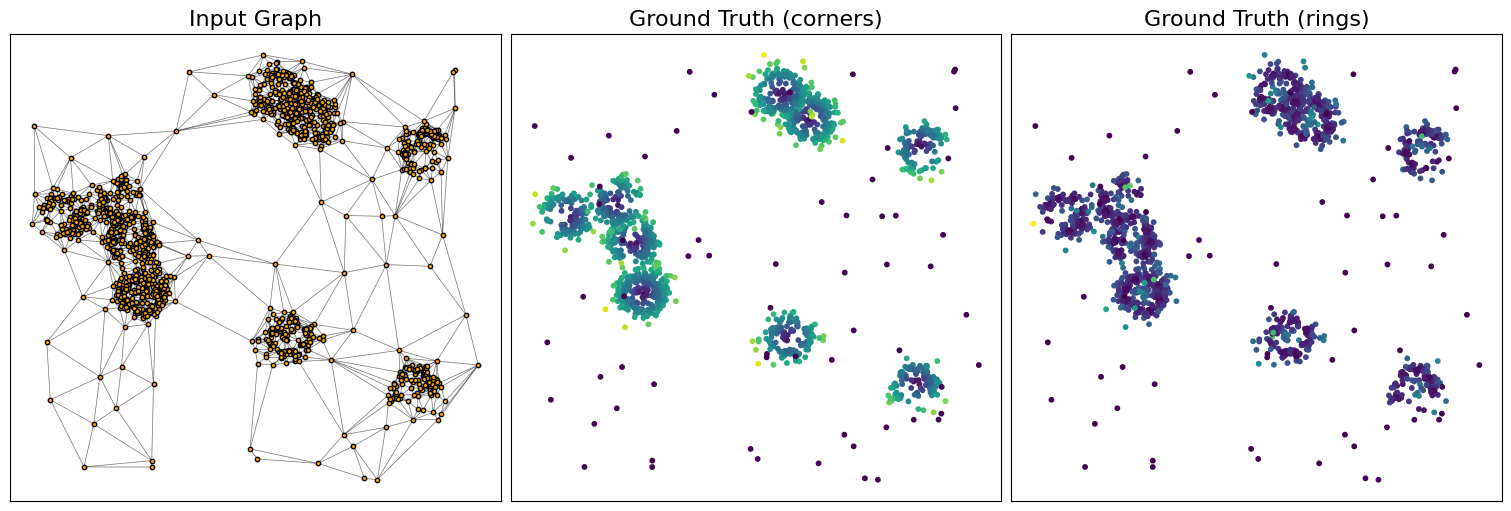

In [7]:
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_training_data(data, figsize=(15, 5), titles=None):
    pos = data["position"]        
    edges = data["edge_index"].T  
    norms = [                    
        None,
        np.linalg.norm(data["y"], axis=1),
        np.linalg.norm(data["y_sub"], axis=1),
    ]

    titles = titles or [
        "Input Graph",
        "Ground Truth (corners)",
        "Ground Truth (rings)",
    ]

    fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)

    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=16)

        if i == 0:
            segments = pos[edges]
            lc = LineCollection(segments, colors="black",
                                linewidths=0.5, alpha=0.3)
            ax.add_collection(lc)
            ax.scatter(pos[:, 0], pos[:, 1],
                       s=10, c="orange", edgecolors="black", zorder=2)
        else:
            im = ax.scatter(pos[:, 0], pos[:, 1],
                            c=norms[i], s=10)

    return fig, axes


idx = random.randrange(len(training_dataset))
fig, axes = plot_training_data(training_dataset[idx])
plt.show()

### **3. Create the model**


Now, instantiate **MIRO** using the configuration that matches the training data. 

The model is initialized with a set of key parameters: the number of output features (in this case, 2 for the predicted *x* and *y* displacements), the connectivity radius used to construct the input graphs (which should match the one used during augmentation), the number of recurrent message-passing iterations to apply on the input graphs (set to 20 by default), and `cutoff_iterations`, which defines how many of those iterations are run at the smaller spatial scale before switching to the larger one.

In this example, the total 20 recurrent iterations are split into the first 10 focused on the corner-scale structures, and the remaining 10 on the rings. 

In [8]:
import deeplay as dl

clusterer = dl.mMIRO(
    num_outputs=2,  # Number of output features (e.g., x, y displacements)
    connectivity_radius=builder.connectivity_radius,  # Radius for graph connectivity (matches dataset)
    num_iterations=20,  # Number of iterations for graph processing
    cutoff_iterations=10, # Number of iterations at the smaller scale before switching to the larger one
)
clusterer = clusterer.create()

print(clusterer)

mMIRO(
  (model): RecurrentMessagePassingModel(
    (encoder): Parallel(
      (0-1): 2 x MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LinearBlock(
            (layer): LazyLinear(in_features=0, out_features=256, bias=True)
            (activation): Identity()
          )
        )
      )
    )
    (backbone): RecurrentGraphBlock(
      (combine): CatDictElements()
      (layer): Sequential(
        (0): Parallel(
          (0-1): 2 x MultiLayerPerceptron(
            (blocks): LayerList(
              (0): LinearBlock(
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
                (activation): Identity()
              )
            )
          )
        )
        (1): MessagePassingNeuralNetwork(
          (blocks): LayerList(
            (0): TransformPropagateUpdate(
              (transform): Transform(
                (combine): Cat()
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
            

### **4. Train the model**


Set up the data loaders and configure the training parameters.

In [9]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(
    dataset=training_dataset,  # The dataset to be loaded
    batch_size=4,  # Number of samples per batch
    shuffle=True,  # Shuffle the dataset at every epoch
)

# Initialize the trainer
trainer = dl.Trainer(max_epochs=30)  # Maximum number of training epochs

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Finally, train **MIRO**. 

Alternatively, you can load a pre-trained model by setting `train_model = False`.

In [ ]:
import torch

train_model = True

if train_model:
    trainer.fit(
        clusterer,  # The MIRO model to be trained
        train_loader,  # The DataLoader providing the training data
    )
else:
    clusterer.load_state_dict(torch.load("models/checkpoint.pt"))  # Load pre-trained model weights

### **5. Test the model**


Once training is complete, it’s time to evaluate **MIRO** on experimental data obtained from SMLM imaging of Nup96-nMaple in fixed U2OS cells ([Thevathasan, J.V. et al. *Nat Methods* (2019)](https://www.nature.com/articles/s41592-019-0574-9)).


In [13]:
test_data = pd.read_csv("data/mMaple_fixed-D2O_190510_16_sml.csv")

Before applying **MIRO** to the validation dataset, we normalize the localization coordinates to ensure that the spatial scale of the structures in the test data matches that of the training data.

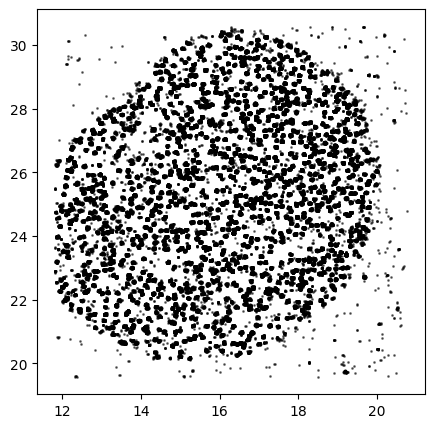

In [14]:
scale = 2000
test_data = test_data.assign(
    x=lambda df: df.xnm / scale,
    y=lambda df: df.ynm / scale,
)

plt.figure(figsize=(5, 5))
plt.scatter(
    test_data["x"],
    test_data["y"],
    s=1,
    c="black",
    alpha=0.5,
)
plt.show()

Now that the test data has been normalized, we proceed to create the graph representation required by **MIRO**. We use the `compute_test_graph` function and set `norm=False` to avoid re-normalizing the data.

Note that this step may take a few minutes, depending on the size of the dataset. Alternatively, a pre-computed graph can be loaded by setting `use_precomputed_graph=True`.

In [ ]:
use_precomputed_graph = False

if use_precomputed_graph:
    test_graph = torch.load("data/test_graph.pt")
else:
    test_graph = lib.compute_test_graph(
        test_data,
        builder=builder,
        norm=False,
    )

We now apply **MIRO** to the test graph to obtain clustering results at multiple spatial scales.

For each scale, we specify the iteration from which to extract node embeddings (`from_iter`), along with the DBSCAN parameters (`eps` and `min_samples`) used to define clusters in the learned representation space.

We also provide a `scaling` factor to convert the normalized coordinates back to physical units (nanometers) before clustering.

The `clusterer.clustering` method applies **MIRO** to the test graph, transforms the node features through the trained model, and performs DBSCAN clustering on the resulting representation. The resulting cluster labels for each scale are stored in `test_data` under `clustering_corners` and `clustering_rings`, respectively.


In [19]:
clusterer.eval()
clusterer.to("cuda" if torch.cuda.is_available() else "cpu")

metadata = {
    "corners": {"from_iter": 9,  "eps": 4,  "min_samples": 4},
    "rings":     {"from_iter": 19, "eps": 30, "min_samples": 16},
}

scaling = np.array([2000, 2000])

for scale_name, params in metadata.items():
    test_data[f"clustering_{scale_name}"] = clusterer.clustering(
        test_graph,
        scaling=scaling,
        **params
    )

Finally, we can visualize the clustering results produced by **MIRO**. 

The following code selects a region of interest from the test dataset and plots the cluster assignments for the `corners` and `rings` scales side by side. Each point represents a localization, and points belonging to the same cluster are shown in the same randomly assigned color. Background points are shown in gray with reduced opacity.

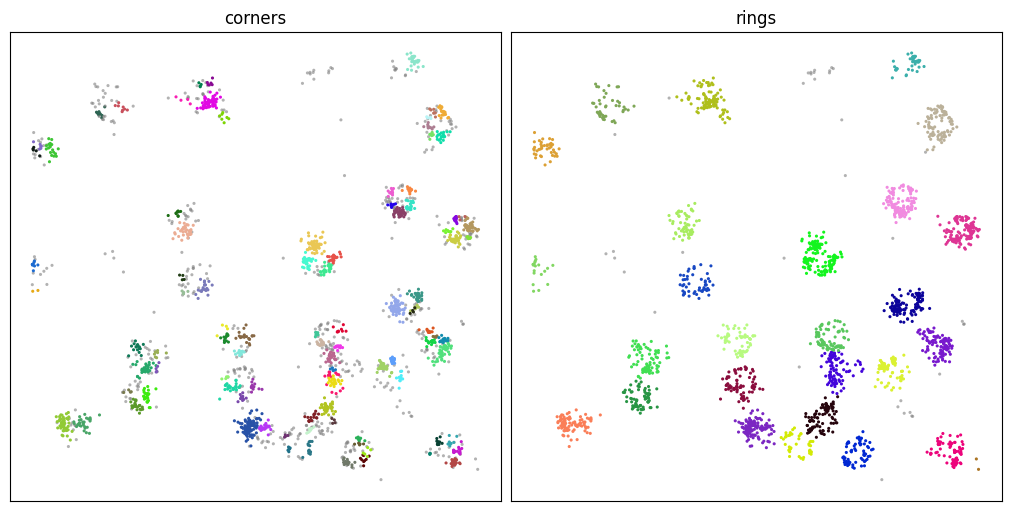

In [20]:
mask = (
    test_data["xnm"].between(29000, 31000)
    & test_data["ynm"].between(51500, 53500)
)
crop = test_data.loc[mask]

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)

scales = ["corners", "rings"]

for ax, scale in zip(axes, scales):
    col = f"clustering_{scale}"
    groups = crop.groupby(col, sort=False)

    for label, group in groups:
        if label == -1:
            color, alpha = "gray", 0.6
        else:
            color = np.random.rand(3)
            alpha = 1.0

        ax.scatter(
            group["xnm"],
            group["ynm"],
            s=5,
            color=color,
            alpha=alpha,
            edgecolors="none",
        )

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f"{scale}", fontsize=12)

plt.show()